In [ ]:
# created by GO 20230613
# purpose: get confidence around trends in temp at Nanoose

# data in: bimonthly anomalies, model and observations for salt and temp
#          as NetCDF (data from Visuals-Data - CTD Obs, Mod at Nanoose (Blind))



In [1]:
import os
import xarray as xr

import cartopy as cp
import matplotlib.pyplot as plt
import numpy as np
import glob

import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm

import time
import datetime as dt

from scipy import interpolate

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
path1 = './climatol_intermediate_files/'
mod_run = "RUN203"
# mod_s_clim_f = 'mod_' + mod_run + '_salinity_1980-2018-climatology.nc'
# mod_t_clim_f = 'mod_' + mod_run + '_temperature_1980-2018-climatology.nc'
# mod_s_bm_f = 'mod_' + mod_run + 'salinity_1980-2018-bimonthly_timeseries.nc'
# mod_t_bm_f = 'mod_' + mod_run + 'temperature_1980-2018-bimonthly_timeseries.nc'

# # climatology and bimonthly time series of temp, salt
# mod_s_clim = xr.open_dataset(os.path.join(path1,mod_s_clim_f))
# mod_t_clim = xr.open_dataset(os.path.join(path1,mod_t_clim_f))
# mod_s_bm = xr.open_dataset(os.path.join(path1,mod_s_bm_f))
# mod_t_bm = xr.open_dataset(os.path.join(path1,mod_t_bm_f))

# # climatol and bm ts from Nanoose data
# obs_ts_bm_f = 'ctd_ts_timeseries_bimonthly.nc'
# obs_s_clim_f = 'obs_salinity_1980-2018-bimonthly_timeseries.nc'
# obs_t_clim_f = 'obs_temperature_1980-2018-bimonthly_timeseries.nc'

# obs_ts_bm = xr.open_dataset(os.path.join(path1,obs_ts_bm_f))
# obs_s_clim = xr.open_dataset(os.path.join(path1,obs_s_clim_f))
# obs_t_clim = xr.open_dataset(os.path.join(path1,obs_t_clim_f))

obs_anom_t_f = 'obs_anom_temp_1980-2018.nc'
obs_anom_s_f = 'obs_anom_salt_1980-2018.nc'
mod_anom_t_f = 'mod_anom_temp_1980-2018.nc'
mod_anom_s_f = 'mod_anom_salt_1980-2018.nc'
obs_anom_t = xr.open_dataset(os.path.join(path1,obs_anom_t_f))
obs_anom_s = xr.open_dataset(os.path.join(path1,obs_anom_s_f))
mod_anom_t= xr.open_dataset(os.path.join(path1,mod_anom_t_f))
mod_anom_s = xr.open_dataset(os.path.join(path1,mod_anom_s_f))    
    

In [3]:
# need to average by depths - gt 4 m
obs_gt4mtemp = obs_anom_t.isel(deptht = obs_anom_t.deptht >4).mean(dim = 'deptht')
mod_gt4mtemp = mod_anom_t.isel(deptht = obs_anom_s.deptht >4).mean(dim = 'deptht')
obs_gt4mtemp = obs_gt4mtemp['temperature']
mod_gt4mtemp = mod_gt4mtemp['temperature']

In [4]:
obs_gt4mtemp['time_counter']

<xarray.DataArray 'time_counter' (time_counter: 936)>
array(['1980-01-07T00:00:00.000000000', '1980-01-23T00:00:00.000000000',
       '1980-02-07T00:00:00.000000000', ..., '2018-11-22T00:00:00.000000000',
       '2018-12-07T00:00:00.000000000', '2018-12-23T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1980-01-07 ... 2018-12-23
    timeperiod    (time_counter) float64 ...

In [5]:
# Function to compute the slope of the linear trend
def compute_slope(x, y):
    regression = LinearRegression()
    regression.fit(x, y)
    return regression.coef_[0]

def compute_slope_GO(x,y):
    m, c = np.linalg.lstsq(x, y, rcond=None)[0]
    return m, c

def get_bootstrapped_CI(n_iter, ts, ts_time):
    values = ts.values[~np.isnan(ts.values)]
    time = ts_time[~np.isnan(ts.values)]
    # Fit linear regression to the original data
    # regression = LinearRegression()
    # regression.fit(time.reshape(-1, 1), values)
    A = np.vstack([time, np.ones(len(time))]).T
    orig_slope, orig_bias = compute_slope_GO(A,values)

    # Initialize an array to store the slopes
    bootstrap_slopes = np.zeros(n_iter)
    bootstrap_biases = np.zeros(n_iter)

    # Perform bootstrapping
    for i in range(n_iter):

        # Generate a bootstrap sample by resampling with replacement
        indices = np.random.choice(len(values), len(values), replace=True)
        bootstrap_sample = values[indices]
        bootstrap_time = time[indices]
        A = np.vstack([bootstrap_time, np.ones(len(bootstrap_time))]).T

        # Compute the slope of the linear trend on the bootstrap sample
    #     bootstrap_slope = compute_slope_GO(bootstrap_time.reshape(-1, 1), bootstrap_sample)
        bootstrap_slope, bootstrap_b = compute_slope_GO(A, bootstrap_sample)
        bootstrap_slopes[i] = bootstrap_slope
        bootstrap_biases[i] = bootstrap_b
        
    return bootstrap_slopes, bootstrap_biases, orig_slope, orig_bias


Original slope: 0.0073
95% Confidence Interval: 0.0048 to 0.0099
Is the trend significant at the 95% level? Yes
Original slope: 0.0060
95% Confidence Interval: 0.0039 to 0.0082
Is the trend significant at the 95% level? Yes


Text(0, 0.5, 'Temp. Anom ($^\\circ$C)')

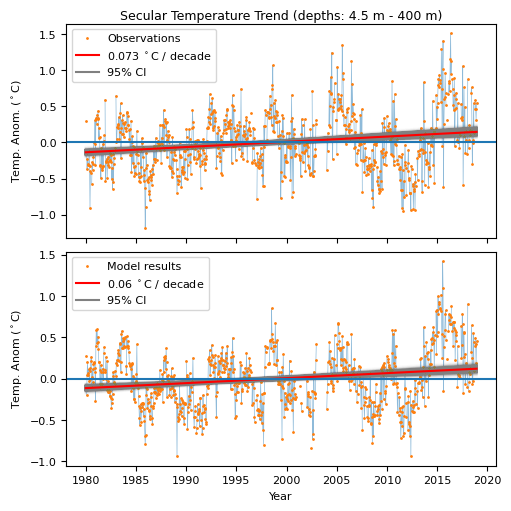

In [36]:
fact = 1

fig, axs = plt.subplots(2,1, figsize=(5*fact, 5*fact), facecolor='w', edgecolor='k', constrained_layout=True)
axs = axs.ravel()
# fig.tight_layout(pad=0.1)

# top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
# axs[0].axhline(y=0)
tyr = np.arange(1980,2019,(1/24))
axs[0].plot(tyr,obs_gt4mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(obs_gt4mtemp.values)]
y = obs_gt4mtemp.values[~np.isnan(obs_gt4mtemp.values)]
# A = np.vstack([x, np.ones(len(x))]).T
# m, c = np.linalg.lstsq(A, y, rcond=None)[0] # old way
axs[0].plot(x, y, '.', label='Observations', markersize=2)
## compute the confidence intervals for the regressions #
# Number of bootstrap iterations
n_iterations = 1000

bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, obs_gt4mtemp, tyr)
confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
# Check if the original slope is within the confidence interval
is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
# Print the results
print(f"Original slope: {orig_slope:.4f}")
print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")
# Plot the linear regression lines from the bootstrap samples
for i in range(n_iterations):
    if i == 0:
        axs[0].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
    else:
        axs[0].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)


axs[0].plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')


axs[1].plot(tyr,mod_gt4mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(mod_gt4mtemp.values)]
y = mod_gt4mtemp.values[~np.isnan(mod_gt4mtemp.values)]
axs[1].plot(x, y, '.', label='Model results', markersize=2)

# bootstrap analysis
bs_slopes, bs_biases, orig_slope, orig_bias = get_bootstrapped_CI(n_iterations, mod_gt4mtemp, tyr)
confidence_interval = np.percentile(bs_slopes, [2.5, 97.5]) # Compute 95% CI
# Check if the original slope is within the confidence interval
is_significant = (confidence_interval[0] <= orig_slope <= confidence_interval[1])
# Print the results
print(f"Original slope: {orig_slope:.4f}")
print(f"95% Confidence Interval: {confidence_interval[0]:.4f} to {confidence_interval[1]:.4f}")
print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")


# Plot the linear regression lines from the bootstrap samples
for i in range(n_iterations):
    if i == 0:
        # get label for legend
        axs[1].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=1, label="95% CI")
    else:
        axs[1].plot(x, bs_slopes[i] * x + bs_biases[i], color='gray', alpha=0.02)

axs[1].plot(x, orig_slope*x + orig_bias, 'r', label=f'{round(orig_slope*10,3)} $^\circ$C / decade')

# reorder legend
plt.sca(axs[0])
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
axs[0].axhline(y=0)

# reorder legend
plt.sca(axs[1])
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'best',fontsize=8)
axs[1].axhline(y=0)

axs[0].set_title('Secular Temperature Trend (depths: 4.5 m - 400 m)', fontsize=9, pad=3)
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelbottom=False)
axs[0].tick_params(axis='y', labelsize=8)
axs[1].tick_params(axis='x', labelbottom=True, labelsize=8)
axs[1].tick_params(axis='y', labelsize=8)
axs[1].set_xlabel('Year', fontsize=8)
axs[0].set_ylabel('Temp. Anom. ($^\circ$C)', fontsize=8)
axs[1].set_ylabel('Temp. Anom ($^\circ$C)', fontsize=8)


In [125]:
values.shape

(850,)

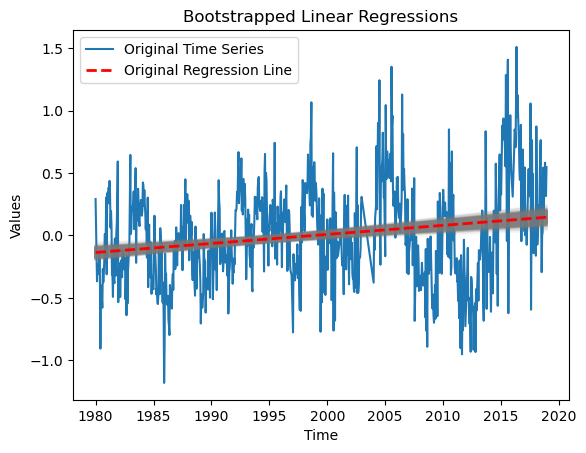

In [133]:
# Plot the original time series
plt.plot(time, values, label='Original Time Series')

# Plot the linear regression lines from the bootstrap samples
for i in range(n_iter):
    plt.plot(time, bootstrap_slopes[i] * time + bootstrap_biases[i], color='gray', alpha=0.05)

# Plot the line from the original regression
plt.plot(time, original_slope * time + original_bias, color='red', linestyle='--', linewidth=2, label='Original Regression Line')

# Add legend and labels
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Bootstrapped Linear Regressions')
plt.legend()

plt.show()

In [50]:
# import numpy as np
# import pandas as pd
# from sklearn.linear_model import LinearRegression

# # Generate sample time series data
# np.random.seed(0)
# time = np.arange(1, 101)
# values = 3 * time + np.random.normal(0, 10, size=100)

# # Fit linear regression to the original data
# regression = LinearRegression()
# regression.fit(time.reshape(-1, 1), values)

# # Function to compute the slope of the linear trend
# def compute_slope(x, y):
#     regression = LinearRegression()
#     regression.fit(x, y)
#     return regression.coef_[0]

# # Number of bootstrap iterations
# n_iterations = 1000

# # Initialize an array to store the slopes
# bootstrap_slopes = np.zeros(n_iterations)

# # Perform bootstrapping
# for i in range(n_iterations):
#     # Generate a bootstrap sample by resampling with replacement
#     indices = np.random.choice(len(values), len(values), replace=True)
#     bootstrap_sample = values[indices]
#     bootstrap_time = time[indices]

#     # Compute the slope of the linear trend on the bootstrap sample
#     bootstrap_slope = compute_slope(bootstrap_time.reshape(-1, 1), bootstrap_sample)
#     bootstrap_slopes[i] = bootstrap_slope

# # Compute the 95% confidence interval for the slopes
# confidence_interval = np.percentile(bootstrap_slopes, [2.5, 97.5])

# # Check if the original slope is within the confidence interval
# original_slope = regression.coef_[0]
# is_significant = (confidence_interval[0] <= original_slope <= confidence_interval[1])

# # Print the results
# print(f"Original slope: {original_slope:.2f}")
# print(f"95% Confidence Interval: {confidence_interval[0]:.2f} to {confidence_interval[1]:.2f}")
# print(f"Is the trend significant at the 95% level? {'Yes' if is_significant else 'No'}")

Original slope: 2.97
95% Confidence Interval: 2.90 to 3.04
Is the trend significant at the 95% level? Yes


In [96]:
A

array([[1.98000000e+03, 1.00000000e+00],
       [1.98008333e+03, 1.00000000e+00],
       [1.98012500e+03, 1.00000000e+00],
       ...,
       [2.01883333e+03, 1.00000000e+00],
       [2.01887500e+03, 1.00000000e+00],
       [2.01891667e+03, 1.00000000e+00]])